In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from IPython.display import display, Markdown

# set up the environment
%matplotlib inline
plt.rc("figure", figsize=(16, 6))  # set default size of plots
sns.set_style("whitegrid")  # set default seaborn style
rng = np.random.default_rng()  # random generator

## Question 9.6 Basket Call Option using Monte Carlo with Antithetic Variates

In [2]:
def European_Basket_Call_MC(S, K, r, cov, q, w, T, L, M):
    A = np.linalg.cholesky(cov)  # Cholesky decomposition
    Z = rng.normal(size=(L, M))  # standard normals
    # Asset prices
    mu = (r - q - 0.5 * np.diag(cov)).reshape(-1, 1)
    ST = S.reshape(-1, 1) * np.exp(mu * T + np.sqrt(T) * (A @ Z))
    # Basket option payoffs at maturity
    C = np.maximum(w.T @ ST - K, 0) * np.exp(-r * T)
    # Monte Carlo estimate of the discounted option price
    C_MC = np.mean(C * np.exp(-r * T))
    # Monte Carlo standard error
    SE = np.std(C * np.exp(-r * T)) / np.sqrt(M)
    return C_MC, SE


def European_Basket_Call_MC_AV(S, K, r, cov, q, w, T, L, M):
    A = np.linalg.cholesky(cov)  # Cholesky decomposition
    Z = rng.normal(size=(L, M))  # standard normals
    # Asset prices
    mu = (r - q - 0.5 * np.diag(cov)).reshape(-1, 1)
    ST1 = S.reshape(-1, 1) * np.exp(mu * T + np.sqrt(T) * (A @ Z))
    ST2 = S.reshape(-1, 1) * np.exp(mu * T + np.sqrt(T) * (A @ -Z))
    # Basket option payoffs at maturity
    C1 = np.maximum(w.T @ ST1 - K, 0)
    C2 = np.maximum(w.T @ ST2 - K, 0)
    # Monte Carlo estimate
    C_MC = np.mean(0.5 * (C1 + C2) * np.exp(-r * T))
    # Monte Carlo standard error
    SE = np.std(0.5 * (C1 + C2) * np.exp(-r * T)) / np.sqrt(M)
    return C_MC, SE

In [3]:
# Parameters
S = np.array([100, 50, 100])
K = 90
r = 0.05
q = np.array([0.01, 0.02, 0.01])
w = np.array([0.2, 0.4, 0.4])  # weights
cov = np.array(
    [[0.09, 0.01, -0.02], [0.01, 0.08, -0.01], [-0.02, -0.01, 0.07]]
)  # covariance matrix
T = 1  # time to maturity
L = 3  # number of assets
M = 1000  # number of simulations

# Simulation (Monte Carlo)
mean_Basket_Call, SE_Basket_Call = European_Basket_Call_MC(S, K, r, cov, q, w, T, L, M)
display(Markdown("**Monte Carlo Results**:"))
display(Markdown(f"Estimate: ${mean_Basket_Call:.4f}"))
display(Markdown(f"Standard error: ${SE_Basket_Call:.4f}"))

# Simulation (Monte Carlo with Antithetic Variates)
mean_Basket_Call_AV, SE_Basket_Call_AV = European_Basket_Call_MC_AV(
    S, K, r, cov, q, w, T, L, M
)
display(Markdown("**Monte Carlo Results with Antithetic Variates**:"))
display(Markdown(f"Estimate: ${mean_Basket_Call_AV:.4f}"))
display(Markdown(f"Standard error: ${SE_Basket_Call_AV:.4f}"))

**Monte Carlo Results**:

Estimate: $2.3272

Standard error: $0.1709

**Monte Carlo Results with Antithetic Variates**:

Estimate: $2.4499

Standard error: $0.1165

As stated in Section 9.4, Monte Carlo with an antithetic variate can help reduce the estimation error.

## Question 9.8 Hedging Cost Comparison

In [4]:
def Simulate_Hedge_Cost(S1, S2, K, r, sigma1, sigma2, rho, q1, q2, Nc, T, M):
    # Cholesky decomposition
    A = np.linalg.cholesky(
        [[sigma1**2, rho * sigma1 * sigma2], [rho * sigma1 * sigma2, sigma2**2]]
    )
    # Standard normals
    Z = rng.normal(size=(2, M))
    # end-of-period asset prices
    S0 = np.array([S1, S2])
    q = np.array([q1, q2])
    sigma = np.array([sigma1, sigma2])
    nu = (r - q - 0.5 * sigma**2).reshape(-1, 1)
    ST1, ST2 = S0.reshape(-1, 1) * np.exp(nu * T + np.sqrt(T) * (A @ Z))
    # end-of-period cost
    cost_a = Nc * (ST1 - np.maximum(ST1 - K, 0)) + \
        Nc * (ST2 - np.maximum(ST2 - K, 0))
    cost_b = Nc * (ST1 + ST2) - 2 * Nc * np.maximum(0.5 * (ST1 + ST2) - K, 0)
    cost_c = Nc * (ST1 + ST2) - 2 * Nc * \
        np.maximum(np.maximum(ST1, ST2) - K, 0)
    return cost_a, cost_b, cost_c

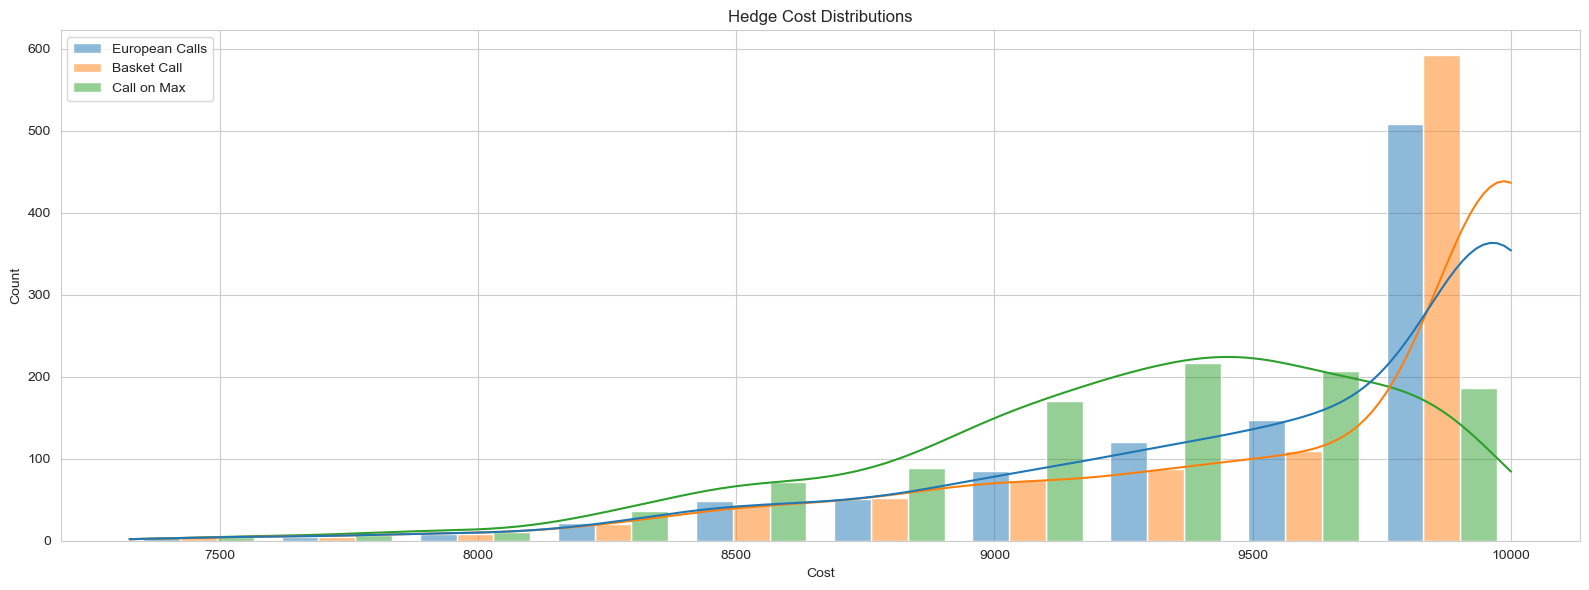

In [5]:
# parameters
S1 = S2 = K = 50  # same initial prices & at-the-money strike
r = 0.05
sigma1 = 0.3
sigma2 = 0.2
rho = 0.5
q1 = 0.02
q2 = 0.01
T = 0.25  # one quarter to maturity
Nc = 100  # number of contracts for each asset
M = 1000  # number of simulations

# Simulation
costA, costB, costC = Simulate_Hedge_Cost(
    S1, S2, K, r, sigma1, sigma2, rho, q1, q2, Nc, T, M
)
cost = pd.DataFrame(
    {"European Calls": costA, "Basket Call": costB, "Call on Max": costC}
)

# Histograms
fig, ax = plt.subplots()
sns.histplot(cost, bins=10, kde=True, ax=ax,
             multiple="dodge", shrink=0.8, legend=True)
plt.title("Hedge Cost Distributions")
plt.xlabel("Cost")
fig.tight_layout()
plt.show()

## Question 9.11. Down-and-out Call: Monte Carlo

In [6]:
def Down_And_Out_Call_MC(S0, K, r, sigma, q, Bar, T, N, M):
    dt = T / N  # time step
    t = np.linspace(0, T, N + 1)  # time grid
    # Brownian motion
    B = np.zeros((M, N + 1))
    B[:, 1:] = np.cumsum(np.sqrt(dt) * rng.normal(size=(M, N)), axis=1)
    # asset prices
    S = S0 * np.exp((r - q - 0.5 * sigma**2) * t + sigma * B)
    # check if barrier is hit
    out = np.any(S < Bar, axis=1)
    # Call option payoffs at maturity
    C = np.maximum(S[:, -1] - K, 0) * (1 - out)
    # Monte Carlo estimate and standard error
    C_MC = np.mean(C * np.exp(-r * T))
    SE = np.std(C * np.exp(-r * T)) / np.sqrt(M)
    return C_MC, SE

In [7]:
# Parameters
S0 = 50
K = 50
r = 0.05
sigma = 0.2
q = 0.02
T = 1
N = 200  # number of time steps
M = 10000  # number of simulations
Bar = 45  # Barrier

# Simulation
DO_MC, DO_SE = Down_And_Out_Call_MC(S0, K, r, sigma, q, Bar, T, N, M)
display(Markdown("**Down-and-out call price (Monte Carlo)**:"))
display(Markdown(f"Estimate: ${DO_MC:.4f}"))
display(Markdown(f"Standard error: ${DO_SE:.4f}"))

**Down-and-out call price (Monte Carlo)**:

Estimate: $3.9171

Standard error: $0.0674

## Question 10.1. Down-and-out Call: Cranck-Nicolson

In [8]:
def Cranck_Nicolson(a, y, L, z1, b1, zL, bL):
    c = np.zeros(L)
    z = np.zeros(L)
    u = np.zeros(L)
    b = np.zeros(L)
    u[0] = z1
    b[0] = b1
    for j in range(1, L - 1):
        z[j] = a[3] * y[j] + a[1] * y[j + 1] + a[2] * y[j - 1]
        u[j] = (a[2] * u[j - 1] + z[j]) / (a[0] - a[2] * b[j - 1])
        b[j] = a[1] / (a[0] - a[2] * b[j - 1])
    c[L - 1] = (zL + bL * u[L - 2]) / (1 - bL * b[L - 2])
    for j in range(L - 2, -1, -1):
        c[j] = u[j] + b[j] * c[j + 1]
    return c


def Down_And_Out_Call_CN(S0, K, r, sigma, q, T, N, M, Dist, Bar):
    # Space grid setup
    dx = Dist / M  # first guess at size of space step
    # distance from barrier to initial stock price
    DistBot = np.log(S0) - np.log(Bar)
    # number of steps from barrier to initial stock price
    NumBotSteps = math.ceil(DistBot / dx)
    dx = DistBot / NumBotSteps  # adjust space step
    # number of steps from initial stock price to the top
    NumTopSteps = math.ceil(Dist / dx)
    DistTop = NumTopSteps * dx  # distance from initial stock price to the top
    L = NumBotSteps + NumTopSteps + 1  # total number of steps
    dt = T / N  # time step
    u = np.exp(dx)  # up factor
    nu = r - q - 0.5 * sigma**2  # drift
    # Coefficients of the tridiagonal matrix
    a = np.zeros(4)
    a[0] = r / 2 + 1 / dt + sigma**2 / (2 * dx**2)
    a[1] = sigma**2 / (4 * dx**2) + nu / (4 * dx)
    a[2] = a[1] - nu / (2 * dx)
    a[3] = -a[0] + 2 / dt
    # Option values at maturity
    C = np.zeros((N + 1, L))
    C[N, :] = np.maximum(Bar * u**np.arange(L) - K, 0)
    # Crank-Nicolson method
    z1 = 0
    b1 = 0
    zL = S0 * np.exp(DistTop) * (1 - 1 / u)
    bL = 1
    for i in range(N - 1, -1, -1):
        C[i, :] = Cranck_Nicolson(a, C[i + 1, :], L, z1, b1, zL, bL)
    return C[0, NumBotSteps]

In [9]:
# Parameters
S0 = 50
K = 50
r = 0.05
sigma = 0.2
q = 0.02
T = 1
N = 100
M = 500  # number of space points above S(0)
Dist = 500  # distance from S(0) to the top
Bar = 45  # Barrier

# Simulation
DO_CN = Down_And_Out_Call_CN(S0, K, r, sigma, q, T, N, M, Dist, Bar)
display(
    Markdown(f"**Down-and-Out Call price (Crank-Nicolson): ${DO_CN:.4f}**"))
display(Markdown(f"**Down-and-Out Call price (Monte Carlo): ${DO_MC:.4f}**"))

**Down-and-Out Call price (Crank-Nicolson): $3.6906**

**Down-and-Out Call price (Monte Carlo): $3.9171**

## Question 10.2. Up-and-out Put: Cranck-Nicolson Method

In [10]:
def Up_And_Out_Put_CN(S0, K, r, sigma, q, T, N, M, Dist, Bar):
    # Space grid setup
    dx = Dist / M  # first guess at size of space step
    # distance from initial stock price to the barrier
    DistTop = np.log(Bar) - np.log(S0)
    # number of steps from initial stock price to the barrier
    NumTopSteps = math.ceil(DistTop / dx)
    dx = DistTop / NumTopSteps  # adjust space step
    # number of steps from initial stock price to the bottom
    NumBotSteps = math.ceil(Dist / dx)
    DistBot = NumBotSteps * dx  # distance from initial stock price to the bottom
    L = NumBotSteps + NumTopSteps + 1  # total number of steps

    dt = T / N  # time step
    d = np.exp(-dx)  # down factor
    nu = r - q - 0.5 * sigma**2  # drift
    # Coefficients of the tridiagonal matrix
    a = np.zeros(4)
    a[0] = r / 2 + 1 / dt + sigma**2 / (2 * dx**2)
    a[1] = sigma**2 / (4 * dx**2) + nu / (4 * dx)
    a[2] = a[1] - nu / (2 * dx)
    a[3] = -a[0] + 2 / dt
    # Option values at maturity
    P = np.zeros((N + 1, L))
    P[N, :] = np.maximum(K - Bar * d**np.arange(L - 1, -1, -1), 0)
    # Crank-Nicolson method
    z1 = S0 * np.exp(-DistBot) * (1 - 1 / d)
    b1 = 1
    zL = 0
    bL = 0
    for i in range(N - 1, -1, -1):
        P[i, :] = Cranck_Nicolson(a, P[i + 1, :], L, z1, b1, zL, bL)
    return P[0, NumBotSteps]

In [11]:
# Parameters
S0 = 50
K = 50
r = 0.05
sigma = 0.2
q = 0.02
T = 1
N = 100
M = 200  # number of space points below S(0)
Dist = 45  # distance from S(0) to the bottom
Bar = 60  # Barrier

# Simulation
P0_CN = Up_And_Out_Put_CN(S0, K, r, sigma, q, T, N, M, Dist, Bar)
display(Markdown(f"**Up-and-Out Put price (Crank-Nicolson): ${P0_CN:.4f}**"))

**Up-and-Out Put price (Crank-Nicolson): $2.5700**